In [2]:
import tensorflow as tf
print(tf.__version__)

2.14.0



# Génération de la série temporelle saisonnière avec tendance et bruit

Dans le code ci-dessous nous allons configurer la série temporelle avec la saisonnalité, la tendance et un peu de bruit.

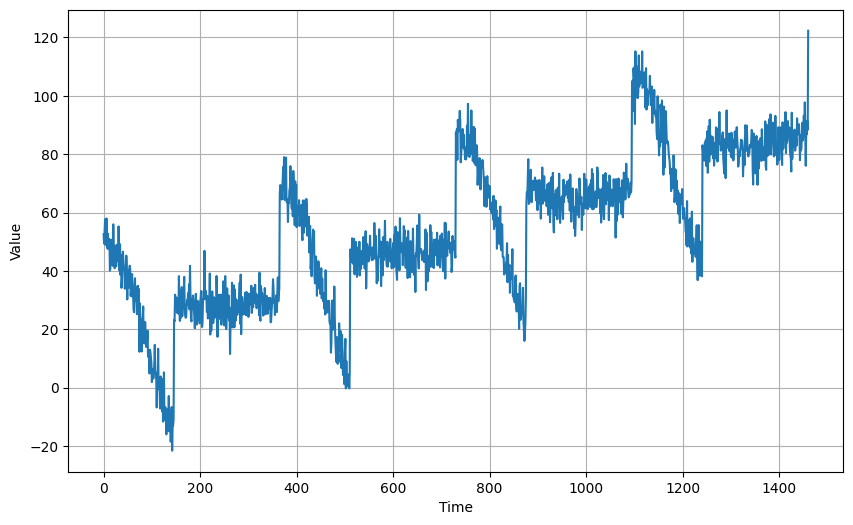

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Juste un pattern arbitraire, qu'on peut changer par ce que l'on veut"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repéter le même pattern à chaque période"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Créer la série temporelle
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Updater la série avec le bruit
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





Maintenant que nous avons la série temporelle, divisons-la afin de pouvoir commencer à faire des prévisions

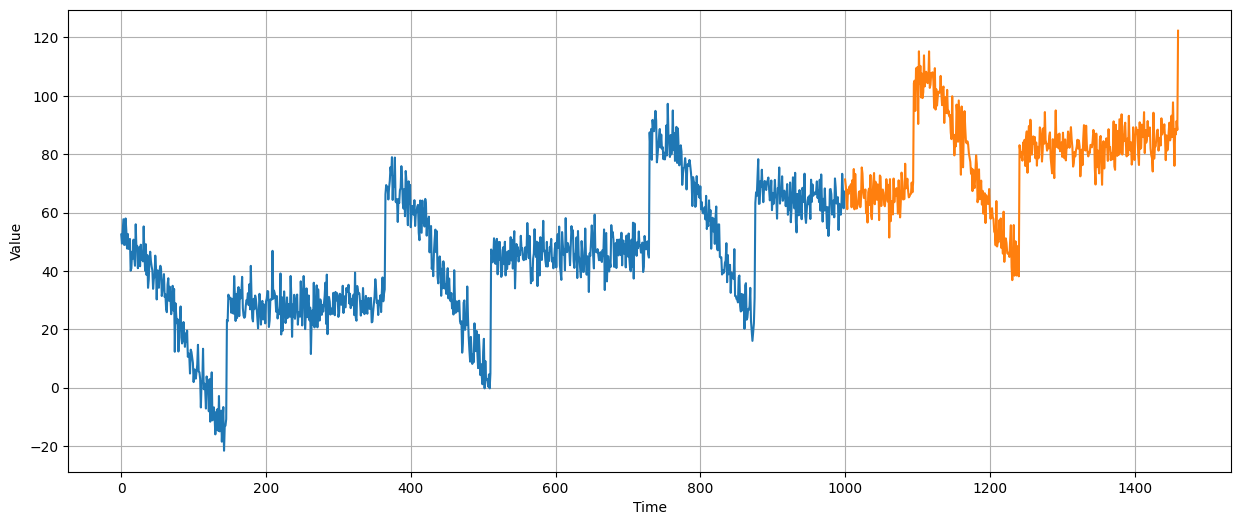

In [4]:
split_time = 1000

# Training set
time_train = time[:split_time]
x_train = series[:split_time]

# Validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Dessin
plt.figure(figsize=(15, 6))
plot_series(time_train, x_train)

plot_series(time_valid, x_valid)
plt.show()

# Prévision naïve  (Naive Forecast)



### Division en Ensembles d'Entraînement et de Validation
1. **Point de Séparation (`split_time`)** :
   - On choisit un point de séparation pour diviser la série en deux : un ensemble d'entraînement (données avant `split_time`) et un ensemble de validation (données après `split_time`).

2. **Création des Ensembles** :
   - Les séries temporelles pour l'entraînement et la validation sont créées en fonction de ce point de division.

3. **Visualisation des Ensembles** :
   - On trace les deux ensembles pour montrer clairement la différence entre les données d'entraînement et de validation.



### Prévision Naïve
1. **Définition de la Prévision Naïve** :
   - La prévision naïve est une méthode de prévision de base où la valeur prévue pour un pas de temps est simplement la valeur observée au pas de temps précédent. C'est une méthode simple mais parfois étonnamment efficace comme point de comparaison pour des modèles de prévision plus complexes.

2. **Application de la Prévision Naïve** :
   - `naive_forecast = series[split_time - 1:-1]` : Cette ligne crée la prévision naïve en décalant la série temporelle d'un pas de temps vers l'avant.

3. **Comparaison avec l'Ensemble de Validation** :
   - On trace la prévision naïve en parallèle avec l'ensemble de validation pour évaluer visuellement la performance de cette méthode de prévision. Cela montre à quel point la prévision naïve suit les données réelles.

### Objectif

- La prévision naïve va servir de point de départ pour comprendre les méthodes de prévision plus avancées et pour évaluer leur performance par rapport à une méthode de base.

In [5]:
naive_forecast = series[split_time - 1:-1]

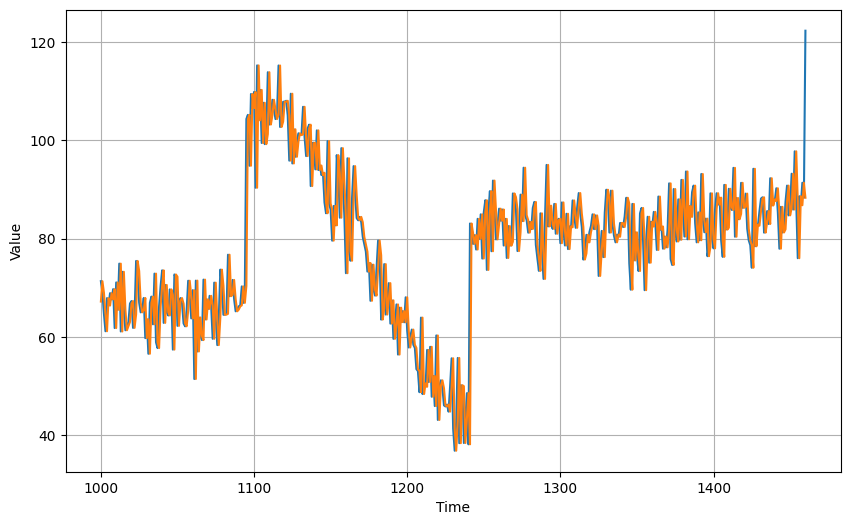

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

# Zoomons sur le début de la période de validation :

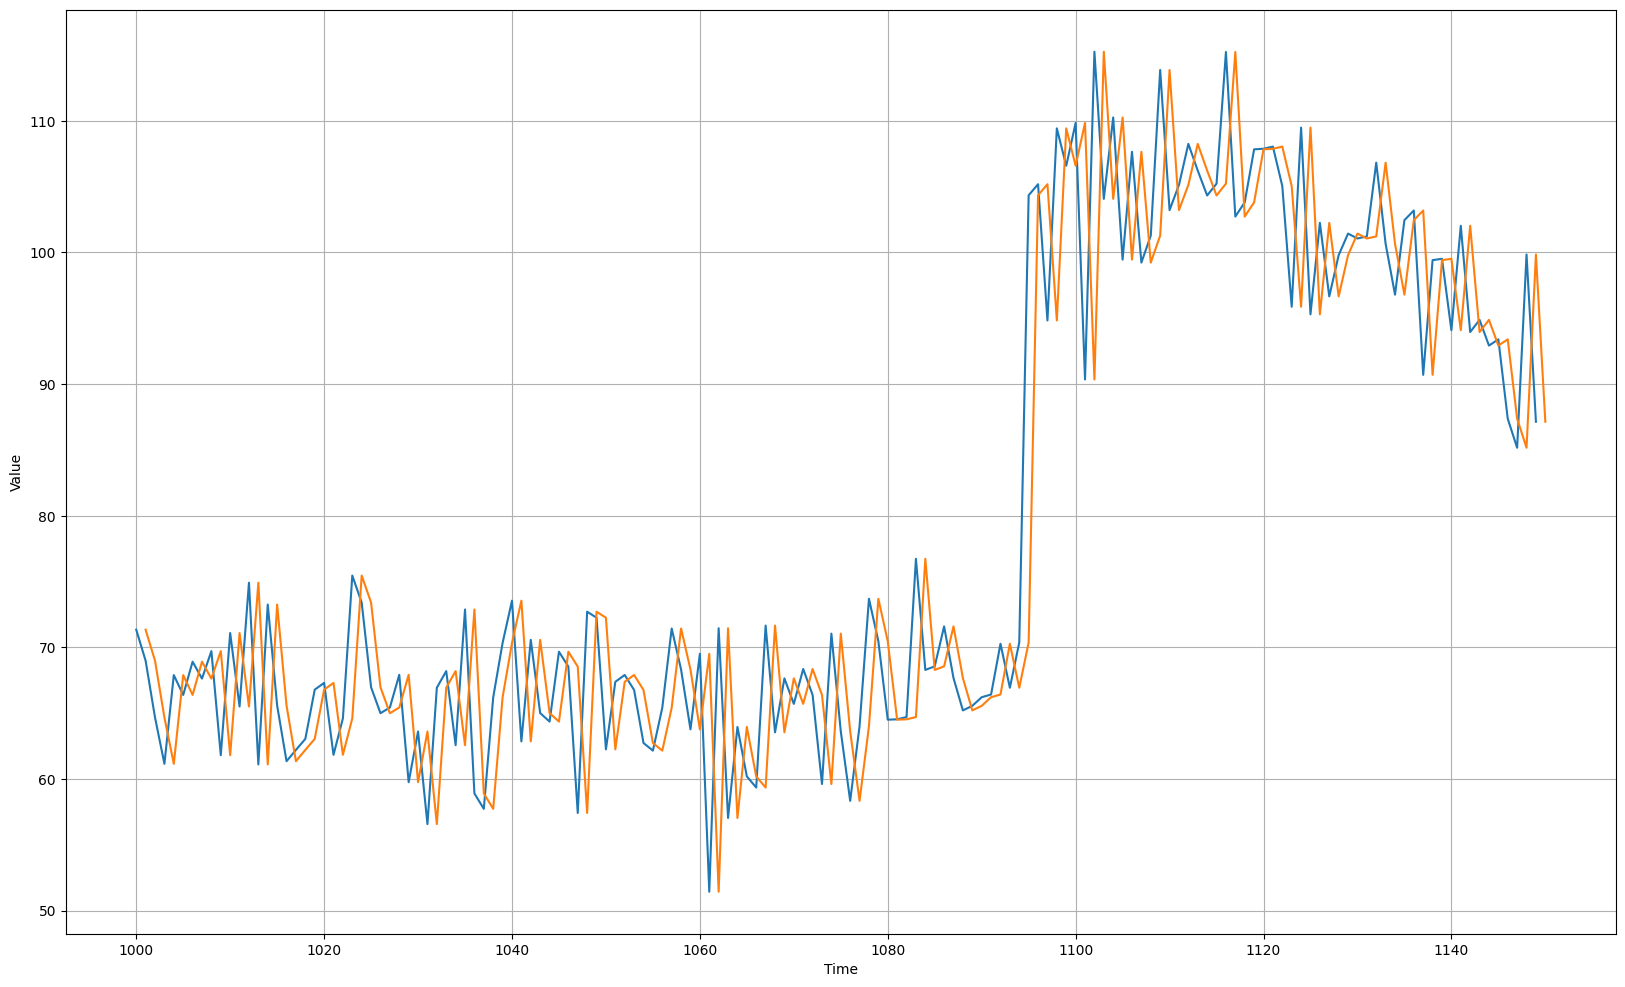

In [7]:
plt.figure(figsize=(20, 12))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

### On peut voir que la prévision naïve est en retard d'un cran par rapport à la série chronologique.

# Erreur du modèle naïf (Naive forecast)

### Calculons maintenant l'erreur quadratique moyenne et l'erreur absolue moyenne entre les prévisions et les prévisions dans la période de validation :

In [8]:
print("\nL'erreur MSE pour naive forecast:", keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print("\nL'erreur MAE pour naive forecast:",keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())


L'erreur MSE pour naive forecast: 61.827534

L'erreur MAE pour naive forecast: 5.9379086


Cette prévision sera notre base de comparaison (baseline), essayons maintenant une moyenne mobile :

In [9]:
naive_forecast2 = naive_forecast[split_time - 1: -1]

# Méthode de la Moyenne mobile      (Moving Average / window averaging)

La fonction `moving_average_forecast` que nous allons définir est un exemple d'une méthode de prévision simple pour les séries temporelles, basée sur la moyenne mobile. Voici une explication détaillée de la fonction et de son utilisation :



### Fonction `moving_average_forecast`
1. **But**:
   - Cette fonction vise à prévoir les valeurs futures d'une série temporelle en utilisant la moyenne des valeurs passées sur une fenêtre glissante de taille spécifiée (`window_size`).

2. **Fonctionnement**:

   - La fonction parcourt la série temporelle (`series`), calculant à chaque fois la moyenne des `window_size` dernières valeurs.

   - Si `window_size` est 1, la prévision est équivalente à la prévision naïve, où la prévision pour le prochain pas de temps est simplement la dernière valeur observée.

3. **Résultat**:
   - La fonction retourne un tableau (`np.array`) contenant les prévisions pour chaque point de la série temporelle, à l'exception des `window_size` derniers points, car il n'y a pas suffisamment de données passées pour eux.


In [10]:
def moving_average_forecast(series, window_size):
  """Prévoire la moyenne des dernières valeurs.
      Si window_size=1, cela équivaut à une prévision naïve"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)


### Application de la Fonction
1. **Calcul de la Prévision**:
   - `moving_avg = moving_average_forecast(series, 30)[split_time - 30:]` :
     - Ici, on applique la fonction sur la série temporelle avec une fenêtre de 30 jours.
     - On sélectionne les prévisions après le `split_time` pour les comparer avec l'ensemble de validation.

2. **Visualisation**:
   - On trace la série de validation (`x_valid`) et la prévision de la moyenne mobile (`moving_avg`) pour comparer visuellement leur performance.



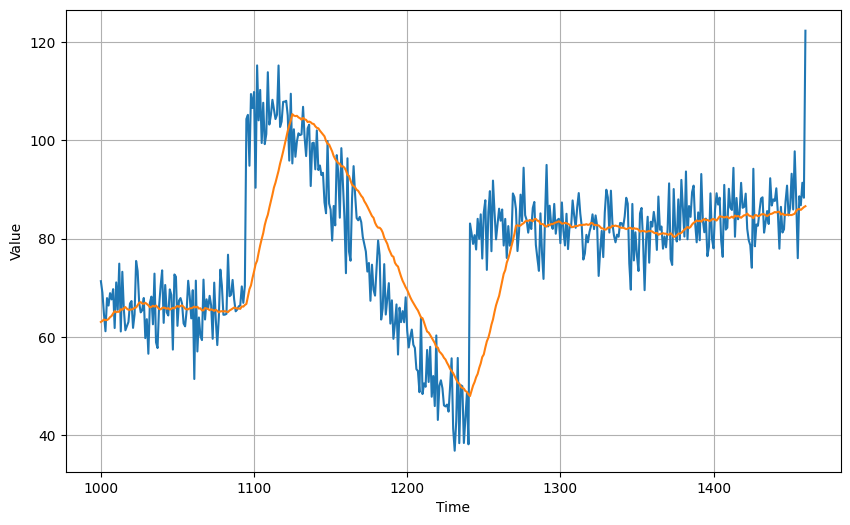

In [11]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

### Mesure de l'Erreur
1. **Erreur Quadratique Moyenne (MSE)**:
   - `keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()` :
     - Cela calcule l'erreur quadratique moyenne entre les valeurs réelles (`x_valid`) et les prévisions. MSE est sensible aux grands écarts car les erreurs sont élevées au carré.

2. **Erreur Absolue Moyenne (MAE)**:
   - `keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()` :
     - MAE mesure l'erreur moyenne en termes absolus entre les prévisions et les valeurs réelles. C'est une mesure plus directe des erreurs moyennes.

### Objectif Pédagogique
- Cette méthode de prévision, basée sur la moyenne mobile, est utile pour lisser la série temporelle et pour faire des prévisions simples.
- Elle sert de base pour comprendre des techniques de prévision plus complexes et pour évaluer leur performance par rapport à des méthodes simples mais efficaces comme la moyenne mobile.
- L'utilisation de MSE et MAE aide à comprendre comment mesurer l'exactitude des prévisions dans les modèles de séries temporelles.

In [12]:
print("\nL'erreur MSE pour la moyenne mobile:", keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print("\nL'erreur MAE pour la moyenne mobile:", keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())


L'erreur MSE pour la moyenne mobile: 106.674576

L'erreur MAE pour la moyenne mobile: 7.142419


##**C'est pire que les prévisions naïves !**

La moyenne mobile **n'anticipe pas la tendance ou la saisonnalité**, essayons donc de les supprimer en utilisant la différenciation.

# Différenciation


### Observation : Prévision Pire que Naïve
- La constatation que les erreurs MSE et MAE pour la moyenne mobile sont pires que celles d'une prévision naïve indique que la méthode de moyenne mobile, dans sa forme actuelle, n'est pas adaptée pour capturer les dynamiques de notre série temporelle.


### Solution Proposée : Différenciation
- **Manque d'Anticipation de la Tendance et de la Saisonnalité** :
  - La moyenne mobile en tant que telle ne tient pas compte de la tendance sous-jacente ou de la saisonnalité. Elle calcule simplement la moyenne des valeurs passées, ce qui peut être problématique pour les séries avec des tendances fortes ou des motifs saisonniers.

- **Utilisation de la Différenciation** :
  - On propose d'utiliser la différenciation pour supprimer la tendance et la saisonnalité de la série temporelle. **La différenciation implique de soustraire la valeur actuelle de la série de sa valeur précédente**.
  - Cette méthode peut aider à rendre la série plus stationnaire, c'est-à-dire avec des propriétés statistiques constantes dans le temps, comme la moyenne ou la variance. Cela peut améliorer les performances de la prévision, en particulier pour les méthodes comme ARIMA, qui nécessitent une stationnarité.



###Puisque la période de saisonnalité est de 365 jours, nous soustrairons la valeur à l'instant *t* – 365 de la valeur à l'instant *t*.

###Le but est de supprimer la tendance et la saisonnalité puisque la moyenne mobile ne les voit pas!

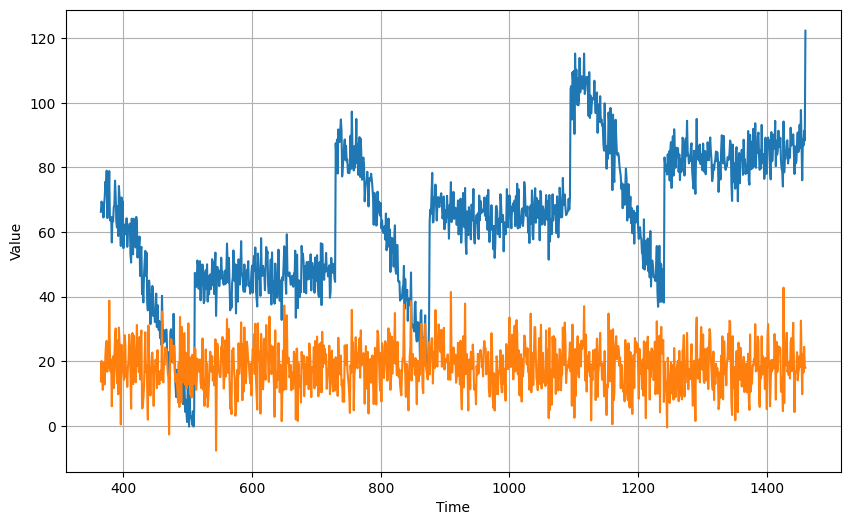

In [13]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))

plot_series(diff_time, series[365:])

plot_series(diff_time, diff_series)

plt.show()

###La tendance et la saisonnalité semblent avoir disparu. Donc, maintenant, nous pouvons utiliser la moyenne mobile:

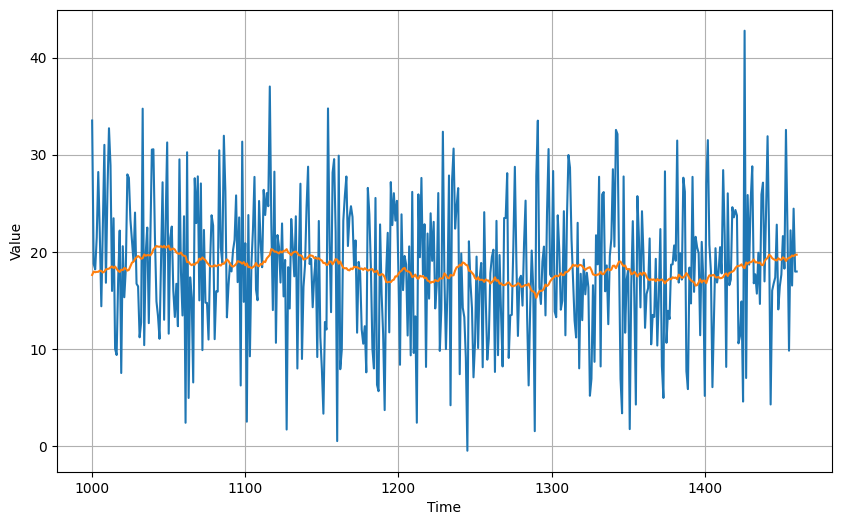

In [14]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]


plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])

#plot_series(time_valid, x_valid)

plot_series(time_valid, diff_moving_avg)
plt.show()

### Ramenons, maintenant, la tendance et la saisonnalité qu'on avait supprimées en **ajoutant les valeurs passées de t à 365**:

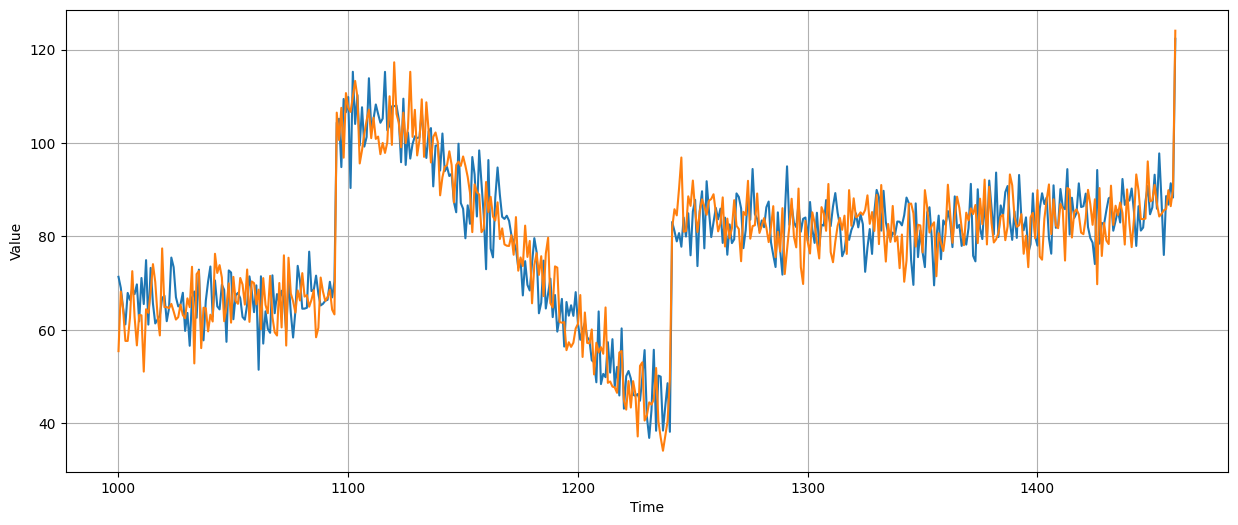

In [15]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [16]:
print("\nL'erreur MSE :", keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print("\nL'erreur MAE :", keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())


L'erreur MSE : 52.97366

L'erreur MAE : 5.8393106


###Mieux que des prévisions naïves.

###Cependant, les prévisions semblent un peu trop aléatoires, car nous ne faisons qu'ajouter des valeurs passées, qui étaient bruyantes.

###Utilisons une moyenne mobile sur les valeurs passées pour supprimer une partie du bruit :

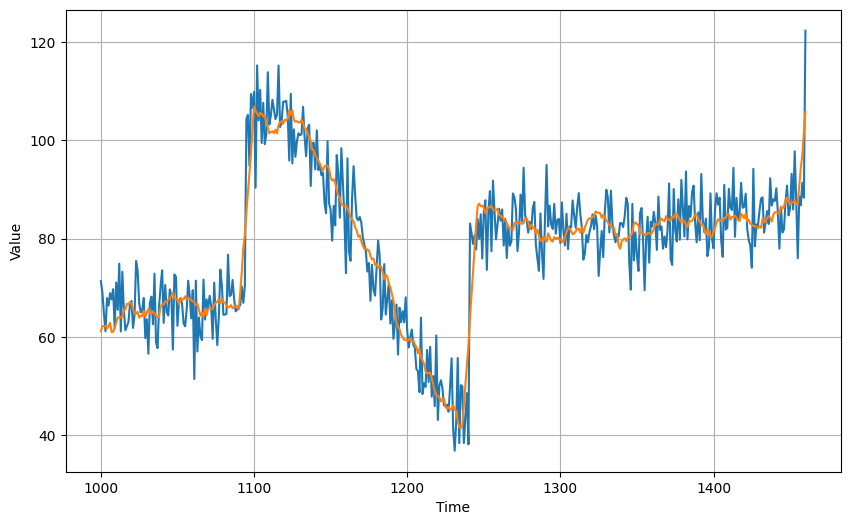

In [17]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [18]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.452267
4.569442


Ex: chercher la meilleur taille de fenetre qui va donner le meilleur MAE, en faisant un découpage logique (soit une semaine, mois, trimistre, semestre, ou une année)
Ex2: reprendre tout le notebook avec une série à deux composantes (multi variate)